## 1D trend filtering

### Introduction

In some real world applications, we want to recover the underlying trend of a series of data (e.g., time series), that is, smooth a noisy time series. For example, we can indentify the trend of the US stock market by filtering the daily return data of S&P 500.

Mathematically, we aim at fitting a time series $\mathbf{y}\in\mathbb{R}^n$ with a piecewise constant vector $\mathbf{\beta}\in\mathbb{R}^n$. 

Note that, the piecewise linearity of a vector can be characterized by the sparsity of its first order difference $\beta_j-\beta_{j-1}, j=2, \cdots,n$.


For $\ell_1$-type methods, such as fuesed lasso [[1]](#refer-anchor-1) [[2]](#refer-anchor-2), this kind of sparsity is obtained by penalizing the $\ell_1$ norm of the first order difference. Specifically, they solve the following problem $$\min\frac{1}{2n}\|\mathbf{y}-\mathbf{\beta}\|_2^2+\|\mathbf{D\beta}\|_1,$$
where 
\begin{align*}
\mathbf{D} = 
\begin{bmatrix}
1 & -1 & 0 & \cdots & 0 & 0\\
0 & 1 & -1 & \cdots & 0 & 0\\
\vdots & \vdots & \vdots & & \vdots & \vdots\\
0 & 0 & 0 & \cdots & 1 & -1\\
\end{bmatrix}.
\end{align*}
That is, we expect that the successive jumps $\beta_j-\beta_{j-1}$ are sparse.

Different from the Lasso-type methods, ``skscope`` is a $\ell_0$-type algorithm.

Therefore, we can solve this problem by considering the following sparse optimization problem
$$\min\frac{1}{2n}\|\mathbf{y}-\mathbf{\beta}\|_2^2\text{ s.t. }\|\mathbf{D\beta}\|_0\leq s.$$
However, this sparse optimization can not be solved by ``skscope`` since it expects a direct sparse parameter (e.g. $\mathbf{\beta}$) rather than a linear transformed one (here $\mathbf{D\beta}$). 

Instead, we reparametrize $\mathbf{\theta}=\mathbf{D\beta}$, that is, we directly let the sparse successive jump be the parameter optimizaed by ``skscope``. 
Then, we represent $\mathbf{\beta}$ with $\mathbf{\theta}$ as $\mathbf{\beta}=\mathbf{Q\theta}$ where
\begin{align*}
\mathbf{Q} = 
\begin{bmatrix}
1 & 0 & 0 & \cdots & 0 & 0\\
1 & 1 & 0 & \cdots & 0 & 0\\
\vdots & \vdots & \vdots & & \vdots & \vdots\\
1 & 1 & 1 & \cdots & 1 & 1\\
\end{bmatrix}.
\end{align*}

Therefore, we can solve the following sparse optimization via ``skscope`` directly
$$\min\frac{1}{2n}\|\mathbf{y}-\mathbf{Q\theta}\|_2^2\text{ s.t. }\|\mathbf{\theta}\|_0\leq s.$$

### Implementation
Under the above formulation, we define the main function ``trend_filter`` as follows. 

Note that, with our reparametrization, the expected piecewise linear vector is directly represented with a sparse ``params`` via the function  ``jnp.cumsum(params)``.

Then, we minimize the mean square loss ``jnp.mean(jnp.square(y - jnp.cumsum(params)))`` with the user-defined sparsity level $k$.

Lastly, we ouput the trend of original data $y$.

In [1]:
import numpy as np
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from skscope import ScopeSolver

import warnings
warnings.filterwarnings('ignore')

In [2]:
def trend_filter(y, k):
    y = jnp.array(y)
    p = len(y)

    # we hope the jump is sparse, thus defining params
    # to be the successive increment of y, i.e.
    # y can be represented as the cumsum of params
    def custom_objective(params):
        return jnp.mean(jnp.square(y - jnp.cumsum(params)))
    
    solver = ScopeSolver(p, k)
    theta_hat = solver.solve(custom_objective)
    y_hat = jnp.cumsum(theta_hat)

    return y_hat

### Synthetic data example
In this example, we generate $\mathbf{y}$ as a $500$-step random walk with normal increment.

In [3]:
# random walk with normal increment
def gen_normal(n_step=500):
    x = np.random.randn(n_step) / np.sqrt(n_step)
    x = np.insert(x, 0, 0)
    y = np.cumsum(x)
    return y

np.random.seed(0)
y = gen_normal(500)

Here, we consider two different sparsity level $k=15, 30$ and visualize the result in the following figure.

The resulted estimator $\widehat{\mathbf{y}}$ is a piece-wise constant line and more jumps exist if $k$ is larger (see the blue and pink lines in the following figure).

Original data $\mathbf{y}$ is zigzag due to the existence of noise. While the smoothed line $\widehat{\mathbf{y}}$ is more smooth and it better exhibit the underlying trend of $\mathbf{y}$.

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


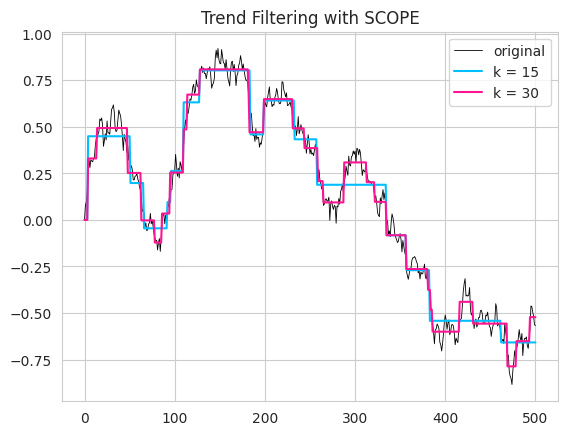

In [4]:
k_list = [15, 30]
color_list= ['deepskyblue', 'deeppink']
sns.lineplot(y, label='original', linewidth=0.6, color='k')
for i in range(len(k_list)):
    k = k_list[i]
    yk = trend_filter(y=y, k=k)
    sns.lineplot(yk, label=r'k = {}'.format(k), color=color_list[i])

plt.legend()
plt.title('Trend Filtering with SCOPE')
plt.show()

# Reference

<div id="refer-anchor-1"></div>

- [1] Tibshirani R, Saunders M, Rosset S, et al. Sparsity and smoothness via the fused lasso[J]. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 2005, 67(1): 91-108.

<div id="refer-anchor-2"></div>

- [2] Kim S J, Koh K, Boyd S, et al. $\ell_1$ trend filtering[J]. SIAM review, 2009, 51(2): 339-360.